# ポワソン回帰
+ 冠動脈心疾患と喫煙習慣

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# cpu がどんな感じで動いているか？
jax.devices()

[CpuDevice(id=0)]

In [3]:
df = pd.DataFrame({
    'agecat': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'deaths': [32, 104, 206, 186, 102, 2,12, 28, 28, 31],
    'population': [52407, 43248, 28612, 12663, 5317, 18790, 10673, 5710, 2585, 1462],
    'smoke': [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
})

データ：「年齢層別に喫煙者と非喫煙者で死亡率がどの程度変化するか（人年が分母）」

Text(0, 0.5, 'Death Rate')

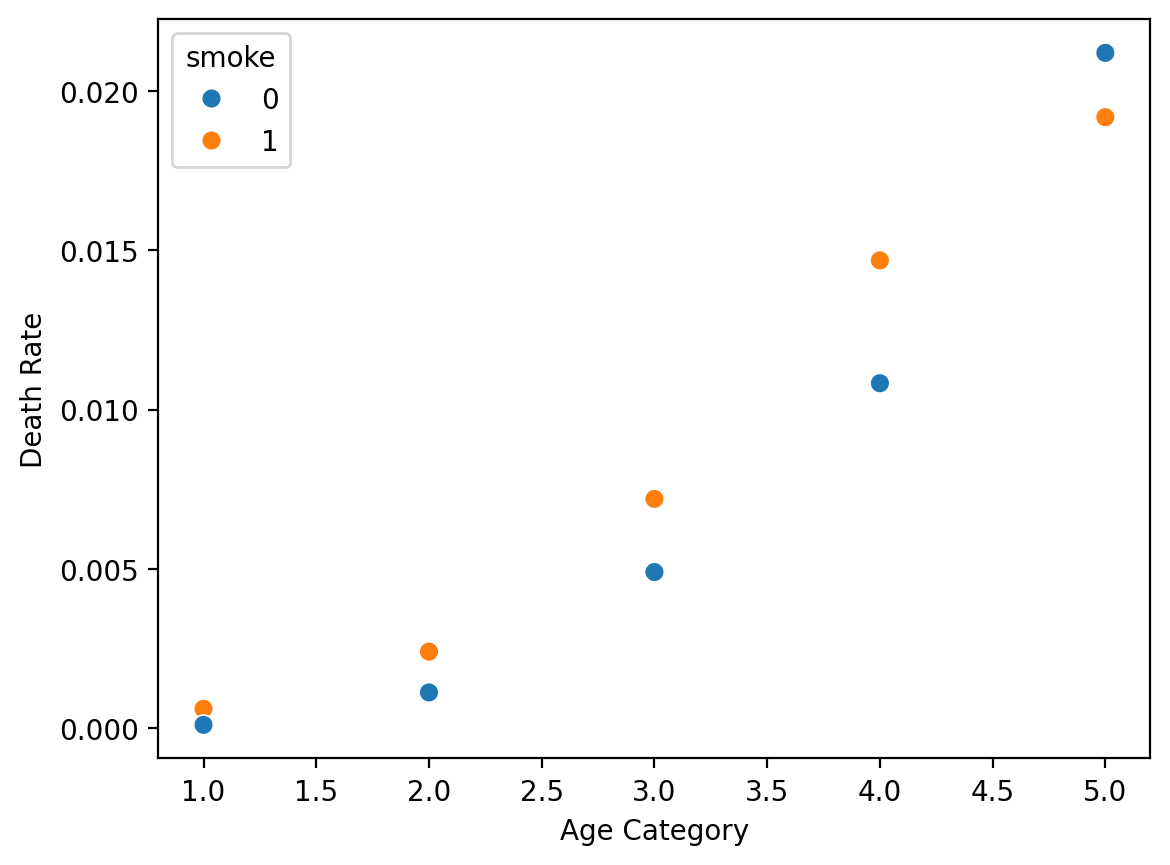

In [8]:
sns.scatterplot(x = df['agecat'], y = df['deaths'] / df['population'], hue = df['smoke'], s = 50)

plt.xlabel("Age Category")
plt.ylabel("Death Rate")

死亡率を対数ケールにするとどうなるか？<br>
本来だったらシンプルなポワソン回帰で説明できるならば以下の図が直線的になるはずだが、そうなってない（曲線っぽい）ので、なんかありそう<br>
あとでモデルの中に `age_scaled` の2乗項 も入れたりする

Text(0, 0.5, 'Death Rate')

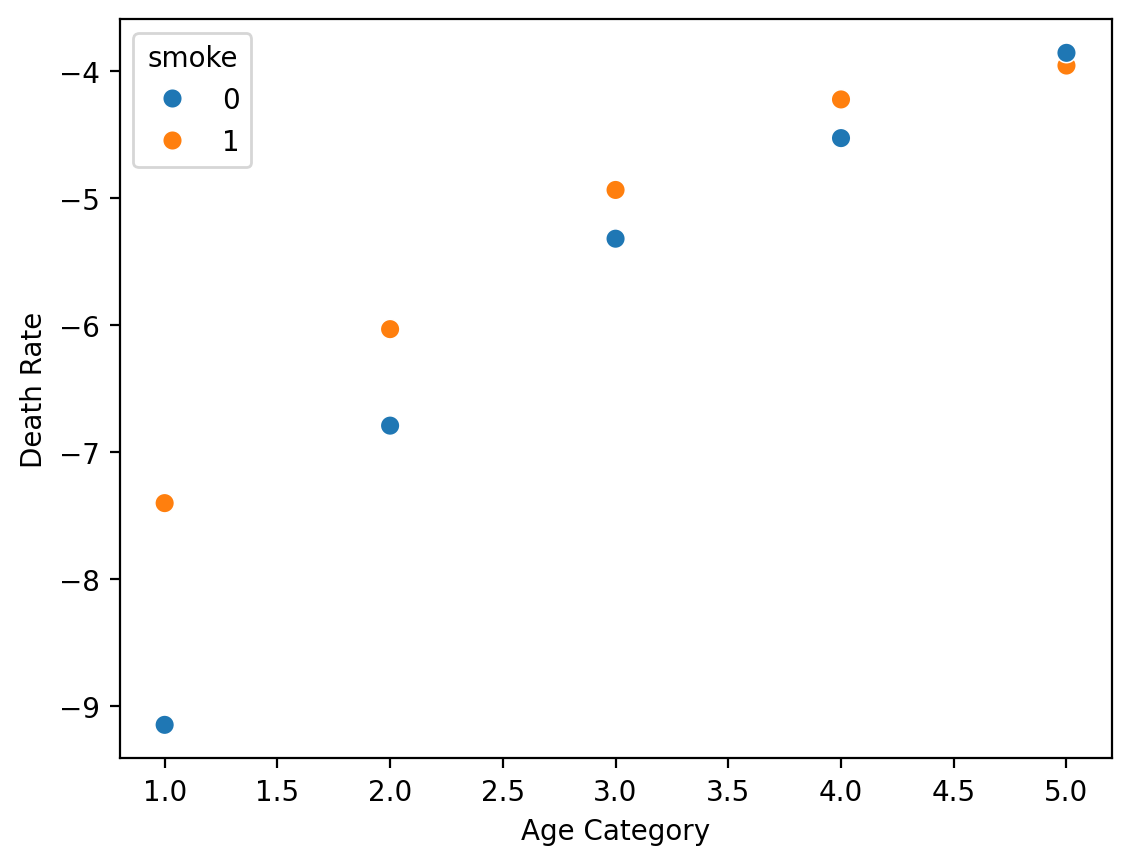

In [9]:
sns.scatterplot(x = df['agecat'], y = np.log(df['deaths'] / df['population']), hue = df['smoke'], s = 50)

plt.xlabel("Age Category")
plt.ylabel("Death Rate")

In [10]:
agecat = df['agecat'].values
deaths = df['deaths'].values
smoke = df['smoke'].values

population = df['population'].values

回帰の場合は標準化<br>
（年齢区分は離散のカテゴリーデータだが、順序があるので一応連続値の特徴量としてみているため標準化している）

In [11]:
agecat_mu = np.mean(agecat)
agecat_sd = np.std(agecat)

agecat_scaled = (agecat - agecat_mu) / agecat_sd

グラフでは `death rate` として示したが、モデルの中では割り算をせずに offset項 を利用する 

モデル比較のため、ロジスティックの場合のスクリプトを以下に残しておく

In [14]:
def model(smoke = None, agecat_scaled = None, deaths = None, population = None, num_data = 0):

    b1 = numpyro.sample('b1', dist.Normal(0, 10))
    b2 = numpyro.sample('b2', dist.Normal(0, 10))
    b3 = numpyro.sample('b3', dist.Normal(0, 10))

    theta =  b1 + b2 * smoke + b3 * agecat_scaled # 線形予測子 

    mu = jax.numpy.exp(theta) * population # 線形予測子だけだと負の値も取るので正に固定のため exp をとる。
    # そして母数がどの程度あるか Offset で表現：ex. 人年が10倍とかになれば、muもちょうど10倍になるようにするだけ!!

    # mu = jax.numpy.exp(b1) * jax.numpy.exp(b2 * smoke) * jax.numpy.exp(b3 * agecat_scaled) * population
    # こんな感じで 指数関数なので、積の形に変換してそれぞれ独立して指標を評価できる

    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(rate = mu), obs = deaths)

In [15]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)

mcmc.run(jax.random.PRNGKey(42)
         , smoke = smoke
         , agecat_scaled = agecat_scaled
         , deaths = deaths
         , population = population
         , num_data = len(agecat_scaled))

mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_5042/1652558687.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:01<00:00, 3214.
sample: 100%|█| 3500/3500 [00:00<00:00, 11385
sample: 100%|█| 3500/3500 [00:00<00:00, 11273
sample: 100%|█| 3500/3500 [00:00<00:00, 11240


In [16]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'b2'}>, <Axes: title={'center': 'b2'}>],
       [<Axes: title={'center': 'b3'}>, <Axes: title={'center': 'b3'}>]],
      dtype=object)

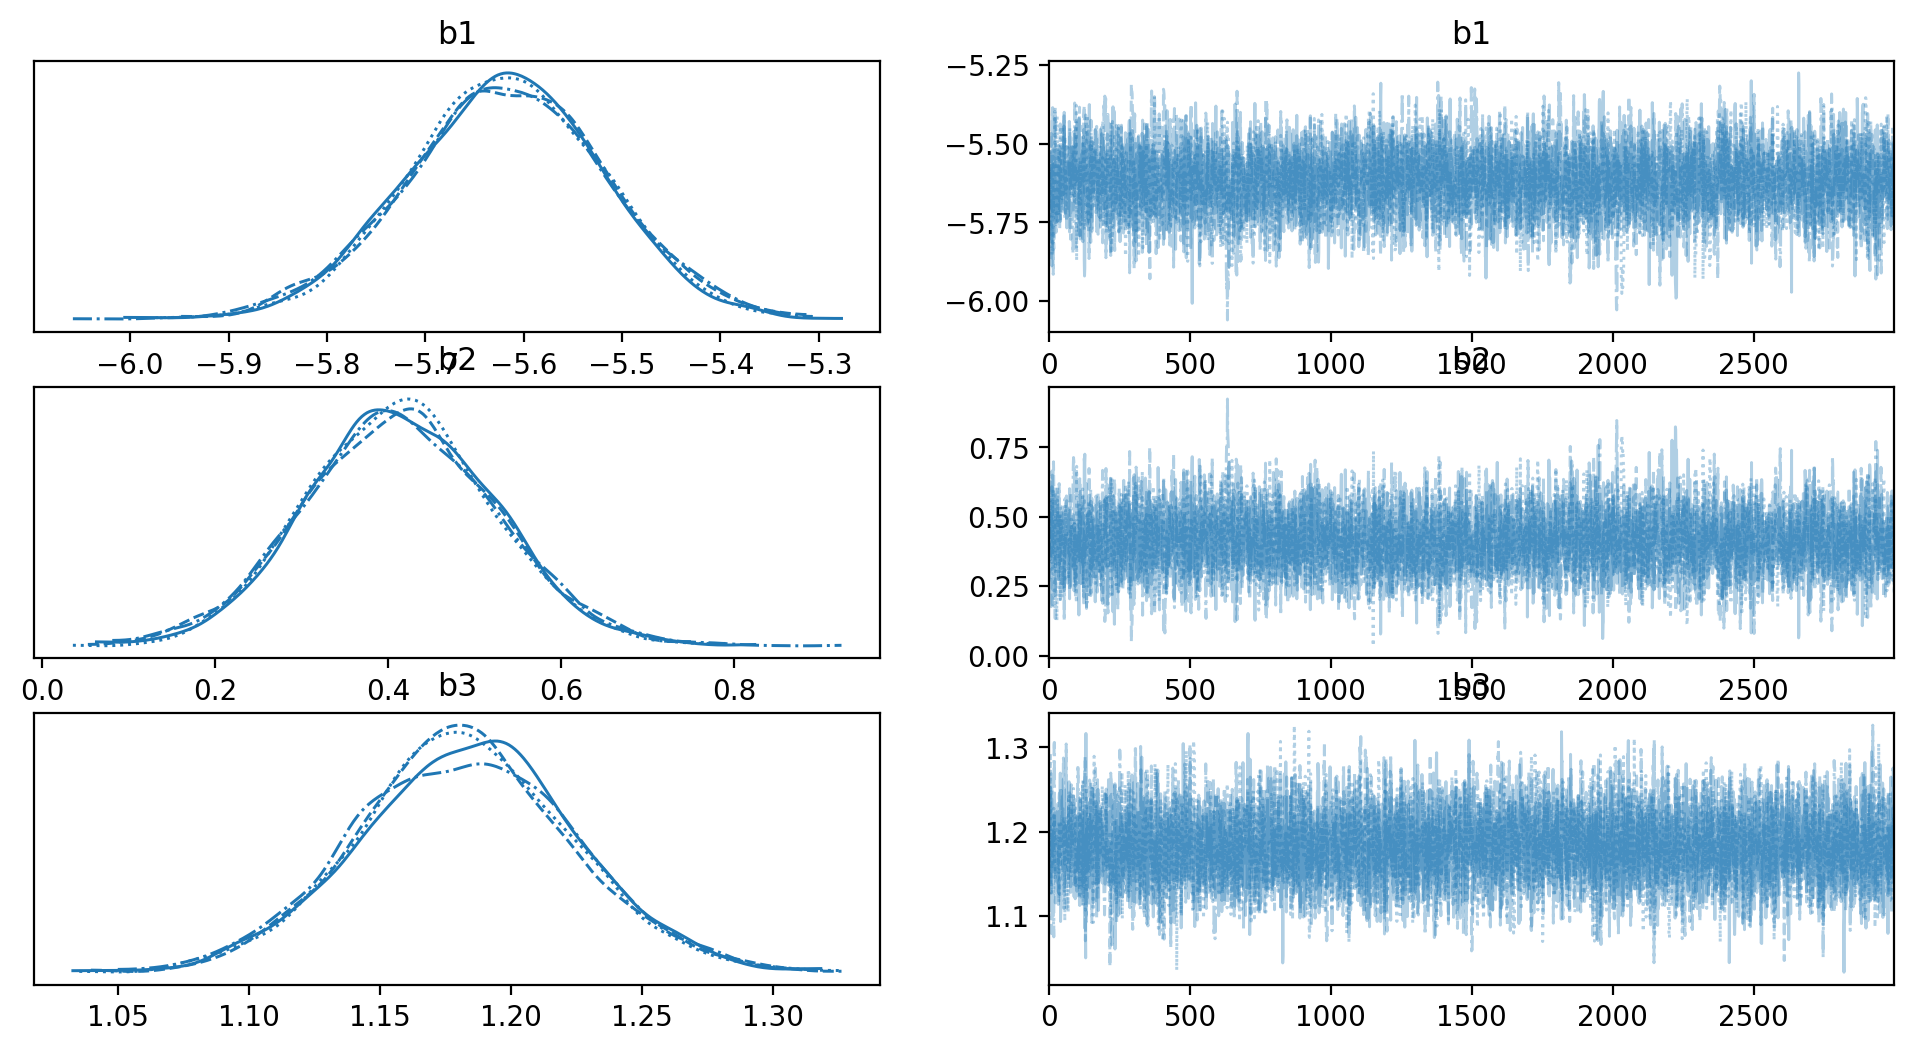

In [17]:
az.plot_trace(idata)

In [18]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1,-5.619,0.101,-5.804,-5.420,0.002,0.001,3974.0,3706.0,1.0
b2,0.413,0.109,0.215,0.624,0.002,0.001,4045.0,4513.0,1.0
b3,1.183,0.041,1.107,1.262,0.001,0.000,6140.0,6127.0,1.0


array([<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b2'}>,
       <Axes: title={'center': 'b3'}>], dtype=object)

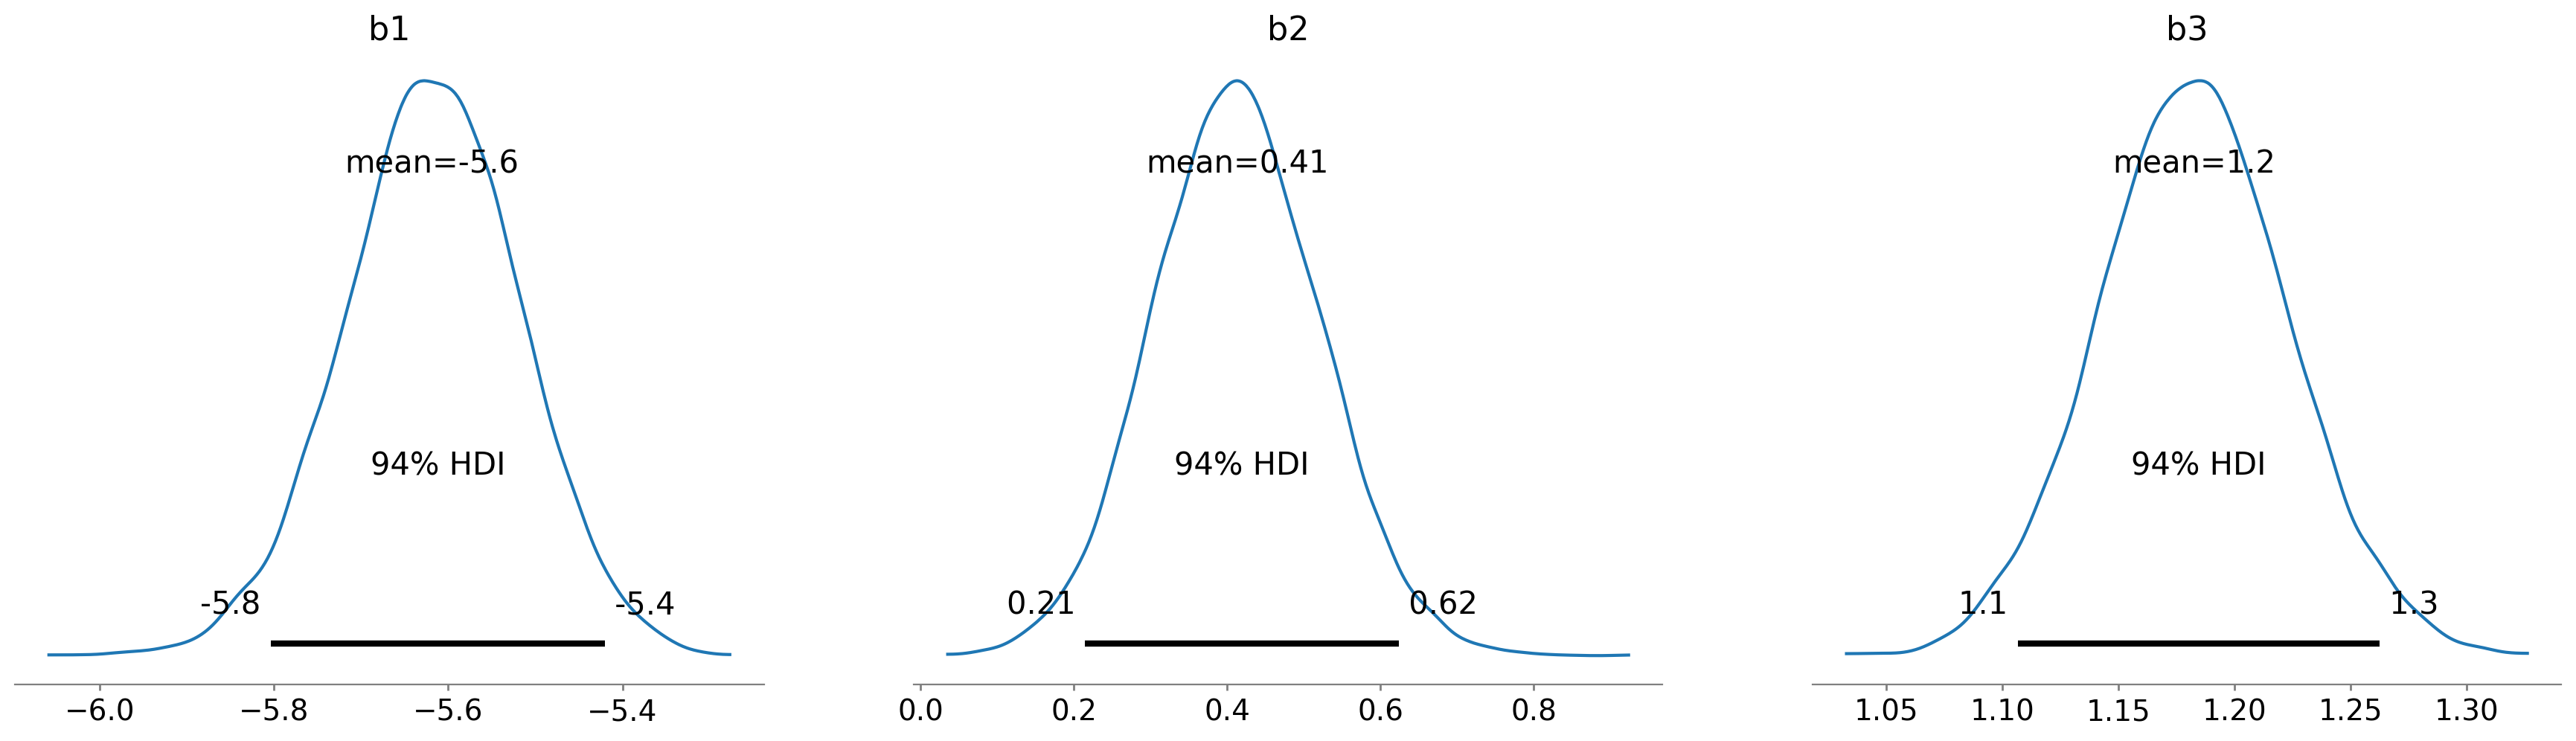

In [19]:
az.plot_posterior(idata)

係数としている `b2`, `b3` いずれも　0からずっと離れていて、両方とも係数としては意味がありそう、ということがわかる

array([<Axes: title={'center': 'b2'}>, <Axes: title={'center': 'b3'}>],
      dtype=object)

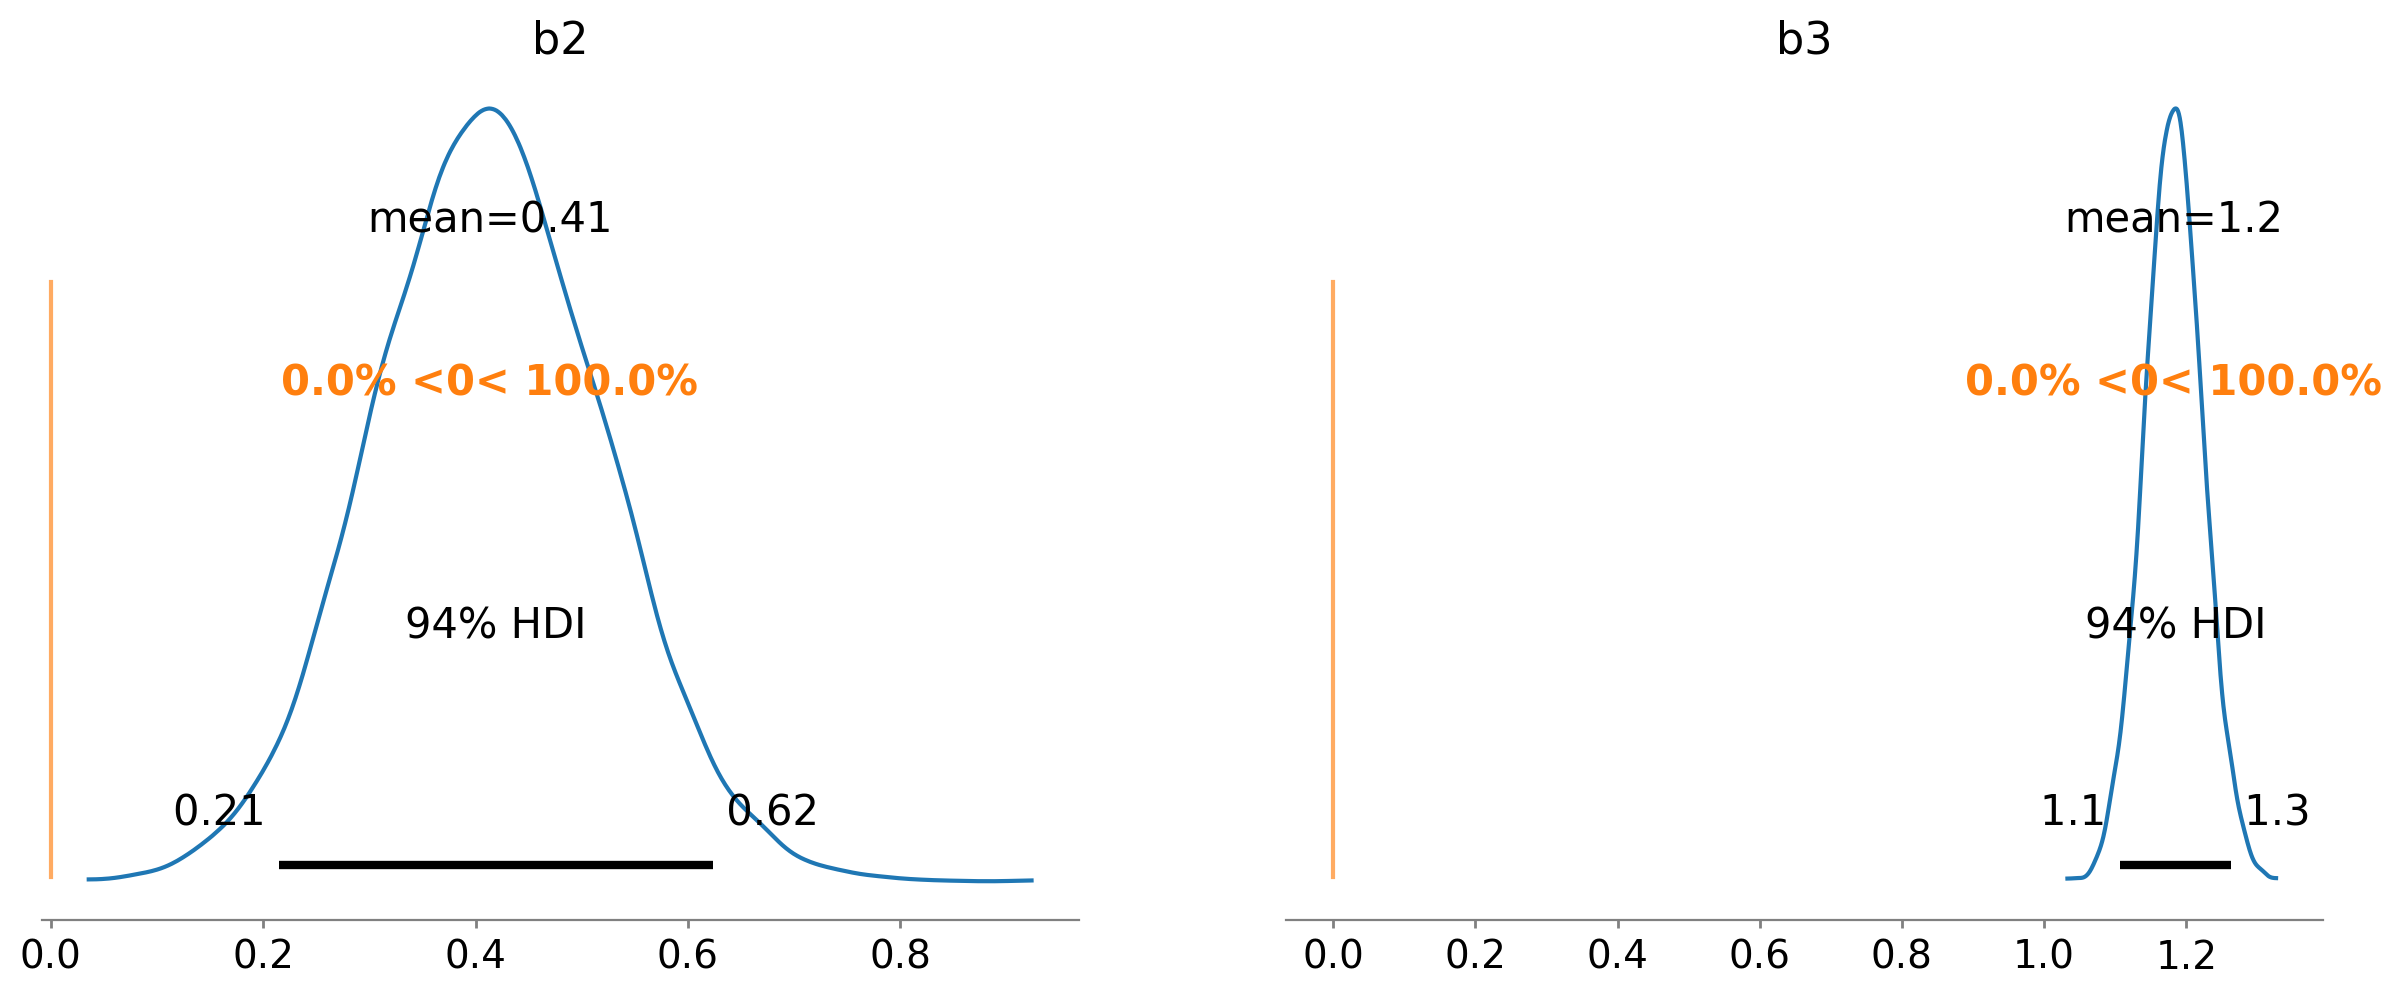

In [28]:
az.plot_posterior(idata, var_names = ['b2', 'b3'], ref_val = 0)

## 事後予測チェック（PPC：Post Predictive Check）
model がちゃんと真のパラメーターを説明できているかどうか

In [20]:
%%time
# 事後予測チェックは mcmc_samples を引数に入れて predictive を生成する

predictive = numpyro.infer.Predictive(model, mcmc_samples)
ppc_samples = predictive(jax.random.PRNGKey(42)
                         , smoke = smoke
                         , agecat_scaled = agecat_scaled
                         , population = population
                         , num_data = len(agecat_scaled))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive = ppc_samples)

CPU times: user 584 ms, sys: 14 ms, total: 598 ms
Wall time: 588 ms


In [22]:
ppc_samples['obs'].shape

(12000, 10)

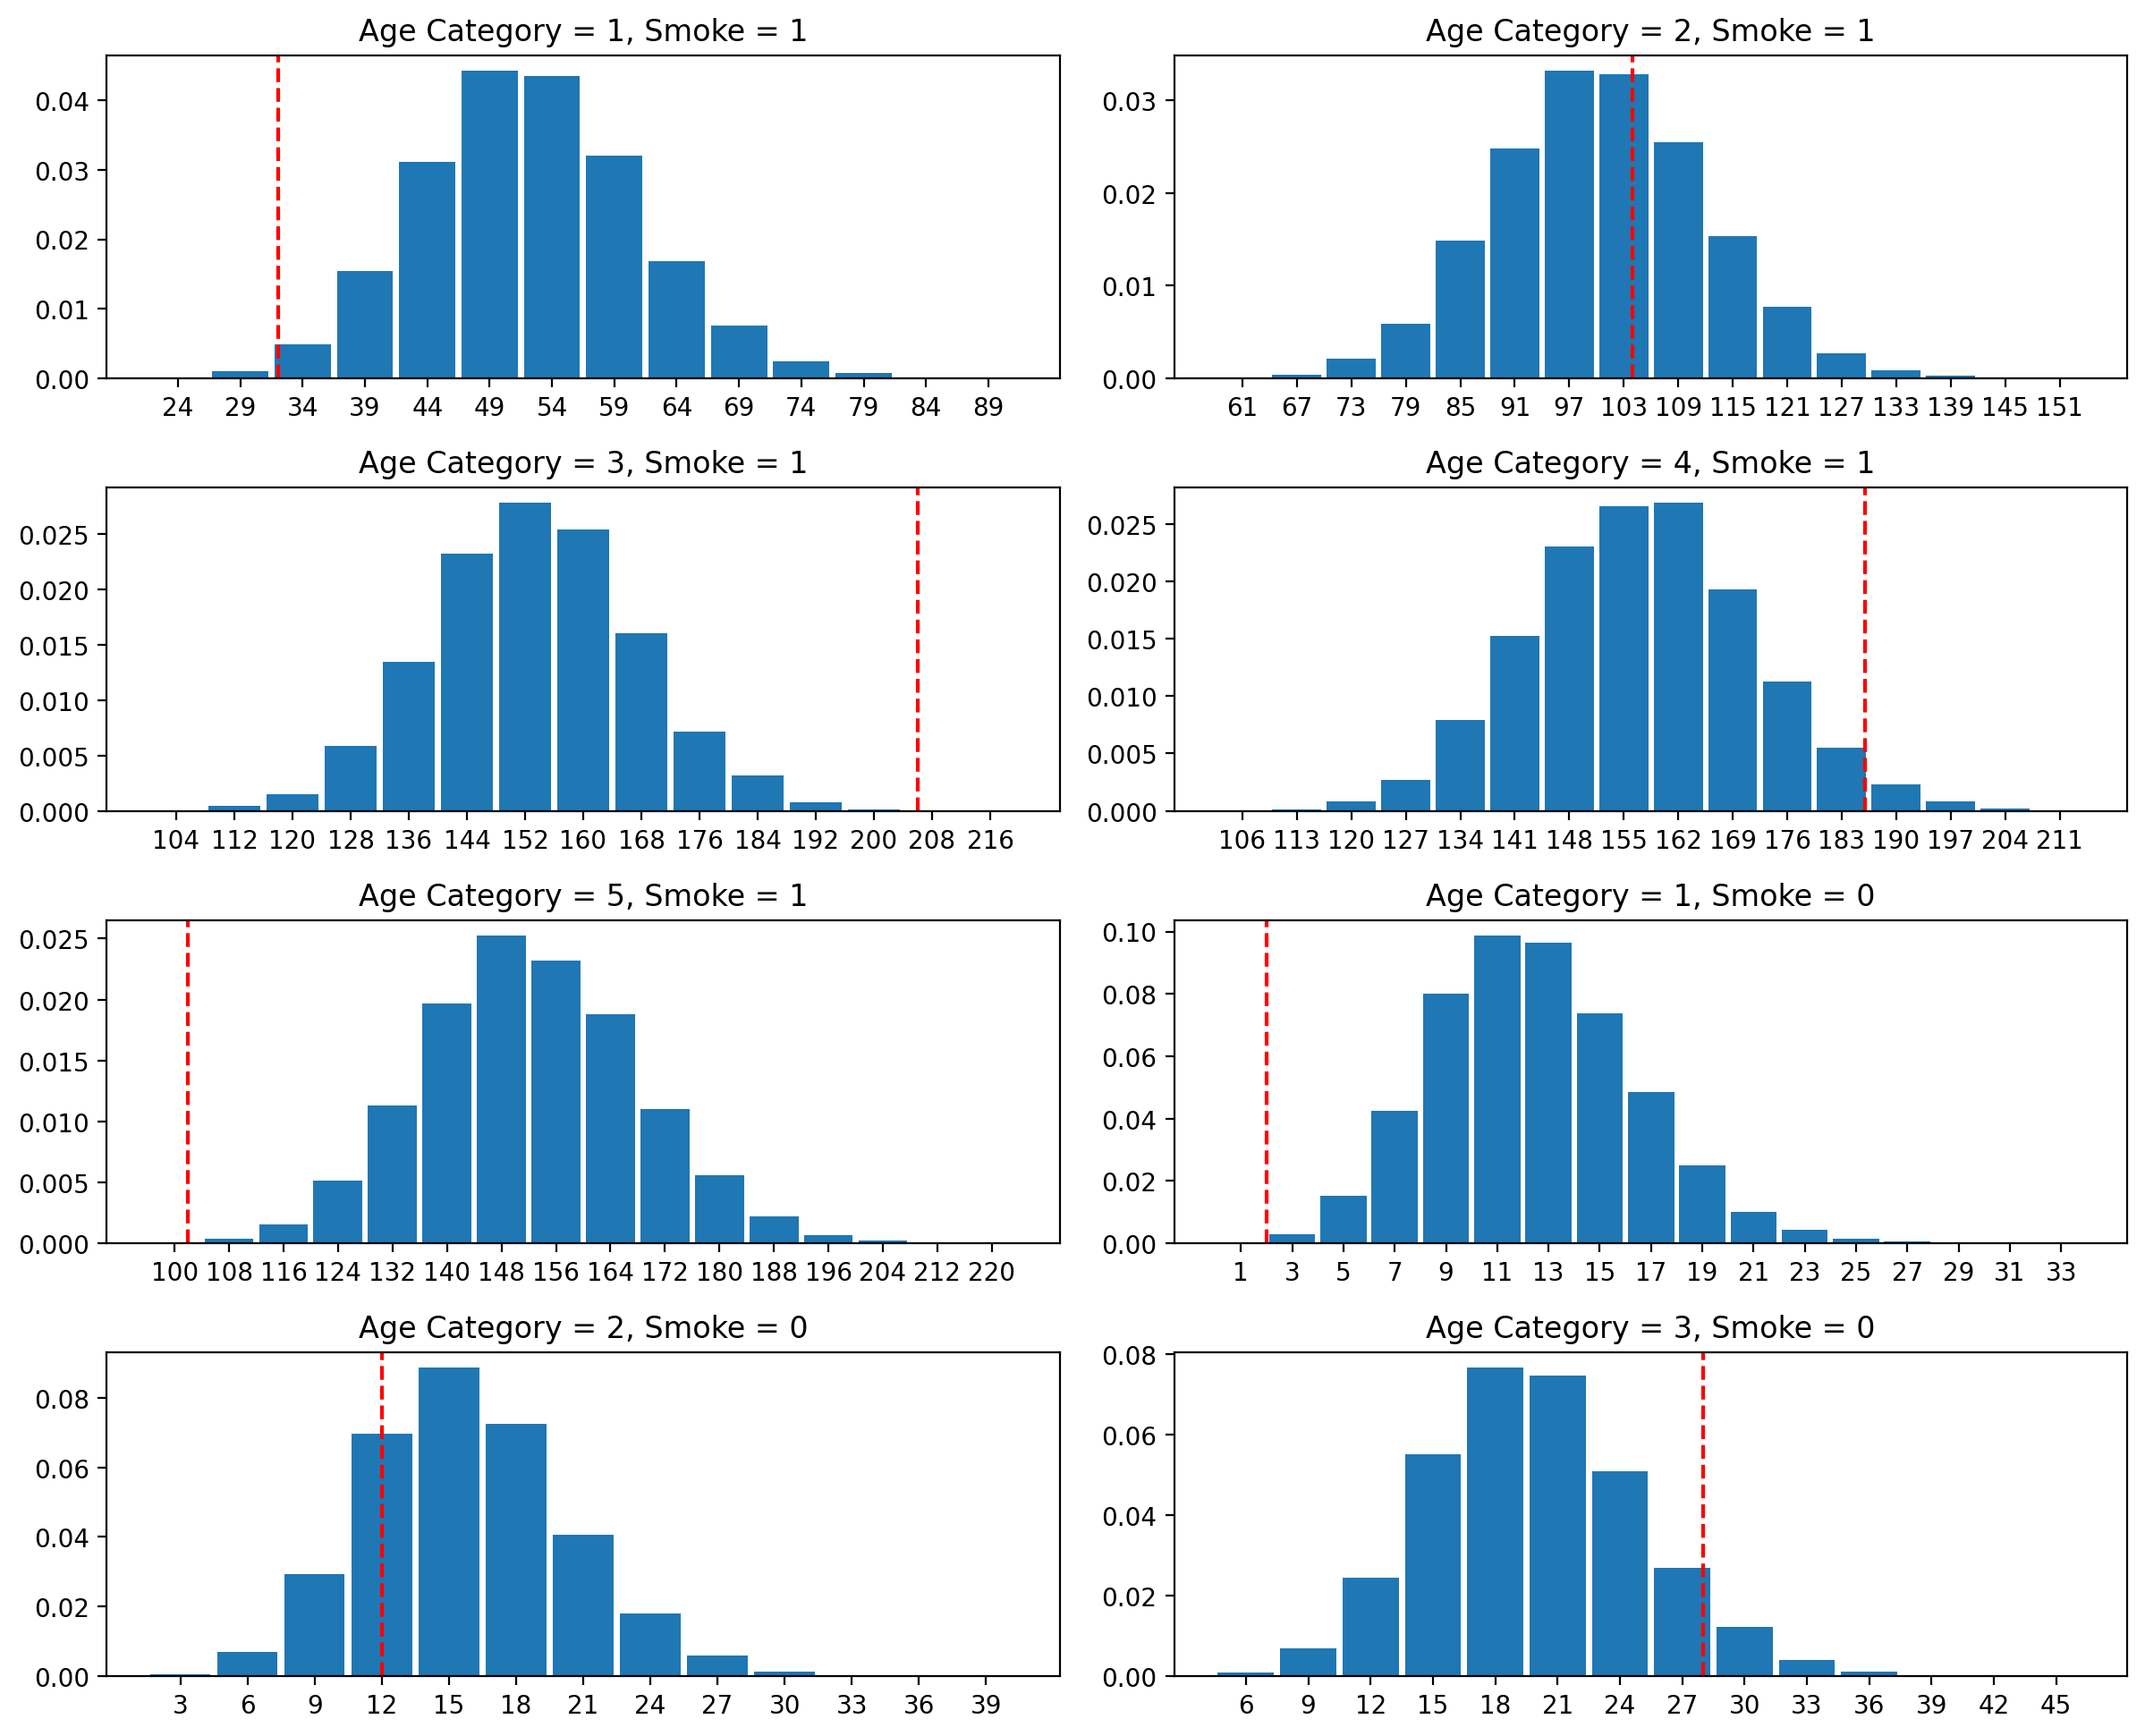

In [26]:
fig = plt.figure(figsize = (12, 12))

for k in range(8):
        
    ax = fig.add_subplot(5, 2, k+1)

    az.plot_dist(ppc_samples['obs'][:, k]) # ppc_samples の　obs なので mcmc で作ったサンプル(実際の観測データ10個に対して)
    ax.axvline(deaths[k], color = 'r', linestyle = 'dashed') # deaths　は実際の観測データ（8個）
    ax.set_title('Age Category = {}, Smoke = {}'.format(agecat[k], smoke[k]))

plt.tight_layout()

**解釈**：結果としては"すごく外れてそう"（わざと）
> + すごく外れたデータはなくモデルがデータをうまく表現できていない<br>
> + すごく変な値（外れ値）がありそう）